## Topic Modeling with Gensim (Python)
#### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=Topic%20Modeling%20is%20a%20technique,in%20the%20Python's%20Gensim%20package 

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # pyLDAvis.gensim raises an error
import matplotlib.pyplot as plt
%matplotlib inline

# enable logging for gensim - optional
import logging
logging.basicConfig(format='$(asctime)s : %(levelname)s : %(messages)s',
                   level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Load dataset

In [2]:
import datetime as dt

# load a file
infile = 'data/CB_RRT0211112.xlsx'
df = pd.read_excel(infile, sheet_name='Sheet1')

# preprocess event datetime
event_datetime_str = list(df['EventDate'].astype(str) + ' ' + df['IncidentTime'].astype(str))
event_datetime_str = [x.replace('1899-12-30 ', '') for x in event_datetime_str]
df['Event_DateTime'] = pd.to_datetime(event_datetime_str, format = '%Y-%m-%d %H:%M:%S')
df['Event_Year'] = df['Event_DateTime'].dt.year

# remove rows with at least one missing in the columns: MRN, Age
df = df.dropna(subset=['MRN', 'Age'])

# split into train/test
df_train = df[df.Event_Year != 2021]
df_test = df[df.Event_Year == 2021]

# create corpora of documents
corpus_train = df_train['BriefFactualDescription']
corpus_test = df_test['BriefFactualDescription']

data = corpus_train

In [4]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Tokenize words and clean up text

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # deacc=True: removes the punctuation

data_words = list(sent_to_words(data))

data_words[:1] # see an example of words split from a document

[['code',
  'sepsis',
  'called',
  'for',
  'low',
  'bp',
  'increased',
  'rr',
  'high',
  'hr',
  'turned',
  'into',
  'rrt',
  'when',
  'map',
  'sustaining',
  'in',
  'high',
  'yo',
  'with',
  'history',
  'of',
  'spinal',
  'cancer',
  'admitted',
  'with',
  'spinal',
  'cord',
  'compression',
  'laminectomy',
  'decompression',
  'of',
  'cauda',
  'equina',
  'tumor',
  'debulking',
  'and',
  'exploration',
  'of',
  'nerve',
  'roots',
  'repeat',
  'staging',
  'done',
  'has',
  'experienced',
  'paroxysmal',
  'afib',
  'with',
  'frequent',
  'episodes',
  'of',
  'afib',
  'with',
  'rvr',
  'converted',
  'with',
  'dig',
  'load',
  'cardizem',
  'gtt',
  're',
  'entered',
  'rapid',
  'fib',
  'not',
  'responsive',
  'to',
  'cardizem',
  'pushes',
  'amio',
  'boluses',
  'gtt',
  'or',
  'cardizem',
  'gtt',
  'hr',
  'afib',
  'drop',
  'in',
  'aline',
  'map',
  'from',
  'high',
  'to',
  'remained',
  'alert',
  'and',
  'oriented',
  'no',
  'compl

### Create bigram and trigram models

In [6]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove stopwords, make bigrams, and lemmatize

In [7]:
def remove_stopwords(texts):
    return [ [w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
## call functions in order

# remove stop words
data_words_nostops = remove_stopwords(data_words) 

# from bigrams
data_words_bigrams = make_bigrams(data_words_nostops) 


# initialize spacy 'en_core_web_sm' model, keeping only tagger component
#     ! python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

# do lemmatization keeping only noun, adj, vb, and adv
data_lemmatized = lemmatization(data_words_bigrams, 
                                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Create a Dictionary and Corpus to be used in Topic Modeling

In [9]:
# create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
df_train.shape[0], len(corpus)

(11248, 11248)

### Build the Topic Model

In [13]:
# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

In [14]:
# print the keyword in the 10 topics
lda_model.print_topics()
doc_lda = lda_model[corpus]

In [15]:
### Compute the model perplexity and coherence score

# model perplexity: the lower, the better
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# coherence socre
coherence_model_lda = CoherenceModel(model=lda_model,
                                    texts=data_lemmatized, dictionary=id2word,
                                    coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence score: ', coherence_lda)


Perplexity:  -10.777850510272202

Coherence score:  0.3919055077415103


In [16]:
### Visualize the topic keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/mini

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.318046  0.141936       1        1  34.862524
8      0.261546  0.145888       2        1  15.524707
15     0.256607 -0.059565       3        1  12.266514
5      0.201586  0.192827       4        1   9.279405
7      0.054851  0.078844       5        1   4.450773
2      0.072030  0.045560       6        1   4.080857
11     0.108851 -0.187876       7        1   3.654587
19     0.083953 -0.292805       8        1   2.888559
0      0.136837 -0.286204       9        1   2.807382
18    -0.047148  0.020501      10        1   2.316822
6     -0.081014  0.023278      11        1   1.639693
12    -0.085394  0.022514      12        1   1.282211
16    -0.112061  0.021218      13        1   1.140879
14    -0.123245  0.004101      14        1   0.876763
1     -0.154241  0.020015      15        1   0.665603
17    -0.160799  0.021340      16        1   0.588119
9     -0.167358  0.023738      17        1   0.569484
4     -0.175360  0.021469      18        1   0.510365
13    -0.178070  0.021488      19        1   0.419918
3     -0.209617  0.021733      20        1   0.174836, topic_info=          Term          Freq         Total Category  logprob  loglift
12        code  12393.000000  12393.000000  Default  30.0000  30.0000
33         icu   6270.000000   6270.000000  Default  29.0000  29.0000
7         call  16763.000000  16763.000000  Default  28.0000  28.0000
58    transfer   4593.000000   4593.000000  Default  27.0000  27.0000
97     primary  10709.000000  10709.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2506  resource      0.036082      1.189053  Topic20 -10.5289   2.8540
2147        rt      0.036082      1.189026  Topic20 -10.5289   2.8540
1977      self      0.036082      1.189069  Topic20 -10.5289   2.8539
2996     istat      0.036082      1.189130  Topic20 -10.5289   2.8539
2239       nrb      0.036082      1.189094  Topic20 -10.5289   2.8539

[800 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
981      10  0.994977       aaox
914      15  0.994635        abd
363       1  0.998760  abdominal
606       6  0.999110        abg
63        2  0.999571       able
...     ...       ...        ...
639      13  0.992061      wound
361       1  0.999468   year_old
362      11  0.998709  yesterday
1459     18  0.993404       zoll
1460     18  0.963926   zoll_pad

[817 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 9, 16, 6, 8, 3, 12, 20, 1, 19, 7, 13, 17, 15, 2, 18, 10, 5, 14, 4])

### Find the optimal number of topics

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word=id2word, num_topics=num_topics,
                                           random_state=100,  update_every=1, chunksize=100, passes=10,   alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, texts=data_lemmatized, start=2,
                                                        limit=24, step=2)

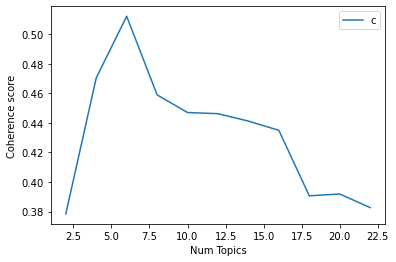

In [21]:
# draw a plot of coherence score vs. num_topics
limit=24; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3784
Num Topics = 4  has Coherence Value of 0.4704
Num Topics = 6  has Coherence Value of 0.5122
Num Topics = 8  has Coherence Value of 0.459
Num Topics = 10  has Coherence Value of 0.447
Num Topics = 12  has Coherence Value of 0.4462
Num Topics = 14  has Coherence Value of 0.4412
Num Topics = 16  has Coherence Value of 0.435
Num Topics = 18  has Coherence Value of 0.3907
Num Topics = 20  has Coherence Value of 0.3919
Num Topics = 22  has Coherence Value of 0.3827


In [34]:
# Select the model and print the topics
optimal_model = model_list[coherence_values.index( max(coherence_values) )]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.060*"pain" + 0.039*"give" + 0.037*"chest" + 0.018*"ekg" + 0.018*"hr" + '
  '0.014*"deny" + 0.012*"place" + 0.012*"arrival" + 0.011*"monitor" + '
  '0.010*"breath"'),
 (1,
  '0.107*"code" + 0.040*"blue" + 0.022*"pulse" + 0.021*"cpr" + 0.016*"start" + '
  '0.016*"intubation" + 0.016*"intubate" + 0.015*"team" + 0.012*"initiate" + '
  '0.011*"place"'),
 (2,
  '0.033*"call" + 0.031*"pt" + 0.023*"rrt" + 0.021*"bedside" + 0.016*"care" + '
  '0.015*"primary" + 0.015*"icu" + 0.014*"bed" + 0.011*"arrival" + '
  '0.011*"transfer"'),
 (3,
  '0.053*"status" + 0.053*"initiate" + 0.052*"follow" + 0.044*"primary" + '
  '0.041*"bedside" + 0.038*"current" + 0.037*"throughout_shift" + '
  '0.036*"level" + 0.034*"notify" + 0.034*"arrival"'),
 (4,
  '0.034*"code" + 0.025*"stroke" + 0.022*"right" + 0.022*"leave" + '
  '0.021*"transport" + 0.021*"ct" + 0.017*"head" + 0.012*"side" + 0.012*"move" '
  '+ 0.011*"fall"'),
 (5,
  '0.027*"blood" + 0.025*"lab" + 0.025*"bolus" + 0.021*"draw" + 0.019*"order"

In [35]:
### Visualize the topic keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/mini

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.100886 -0.007373       1        1  46.042073
5     -0.054167  0.136982       2        1  18.568496
0      0.000473  0.310478       3        1  11.110712
4      0.184381 -0.139688       4        1  10.826328
1      0.262490 -0.100074       5        1   7.058332
3     -0.292291 -0.200326       6        1   6.394059, topic_info=         Term          Freq         Total Category  logprob  loglift
12       code  10895.000000  10895.000000  Default  30.0000  30.0000
122   bedside   9790.000000   9790.000000  Default  29.0000  29.0000
97    primary   9185.000000   9185.000000  Default  28.0000  28.0000
91       pain   6292.000000   6292.000000  Default  27.0000  27.0000
11       care   7615.000000   7615.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2239      nrb    223.511764    704.919976   Topic6  -5.3967   1.6012
51        rrt    589.735771   8648.971019   Topic6  -4.4265   0.0643
193   seizure    231.541717    795.018479   Topic6  -5.3614   1.5162
766   perform    250.749409   1056.097018   Topic6  -5.2817   1.3119
402   provide    168.479712    508.833739   Topic6  -5.6794   1.6445

[358 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
410       2  0.996990    abdoman
363       2  0.852994  abdominal
363       3  0.147034  abdominal
606       1  0.999591        abg
63        1  0.509188       able
...     ...       ...        ...
357       4  0.998068   weakness
663       1  0.961565       well
663       2  0.014115       well
663       3  0.023819       well
864       6  0.984517     writer

[494 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 5, 2, 4])

### Create a dataframe object of the ominant topic and corresponding keywords

In [145]:
list_topic_nums = list(range(optimal_model.num_topics))
list_topic_keywords = ['']*optimal_model.num_topics
for i in range(optimal_model.num_topics):
    list_topic_keywords[i] = ','.join([w for w, p in optimal_model.show_topic(i, topn=20)])

df_dominant_topic = pd.DataFrame(list(zip(list_topic_nums, list_topic_keywords)), columns=['Dominant_Topic', 'Topic_keywords'])
df_dominant_topic

,Dominant_Topic,Topic_keywords
0,0,"pain,give,chest,ekg,hr,deny,place,arrival,moni..."
1,1,"code,blue,pulse,cpr,start,intubation,intubate,..."
2,2,"call,pt,rrt,bedside,care,primary,icu,bed,arriv..."
3,3,"status,initiate,follow,primary,bedside,current..."
4,4,"code,stroke,right,leave,transport,ct,head,side..."
5,5,"blood,lab,bolus,draw,order,sepsis,send,hypoten..."


### Find the dominant topic for each document

In [121]:
def sort_tuple(tup): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of 
    # sublist lambda has been used 
    tup.sort(key = lambda x: x[1], reverse=True) 
    return tup 

In [159]:
n_docs = len(optimal_model[corpus])
dominant_topic = [None]*n_docs
perc_contribution = [0.0]*n_docs
for i in range(n_docs):
    cur_topic, cur_perc = sort_tuple(optimal_model[corpus][i][0])[0]
    dominant_topic[i] = cur_topic
    perc_contribution[i] = cur_perc
    
df_topic_num_score = pd.DataFrame(list(zip(df_train['FileID'], dominant_topic, perc_contribution)),
                                      columns=['FileID', 'Dominant_Topic', 'Topic_Perc_Contribution'])

In [167]:
df_topic_sents_keywords = df_topic_num_score.merge(df_dominant_topic, on='Dominant_Topic', how='left')
df_topic_sents_keywords = df_topic_sents_keywords.merge(df_train.loc[:, ['FileID', 'BriefFactualDescription']], on='FileID', how='left')
df_topic_sents_keywords.columns = ['FileID', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_keywords', 'Text']
df_topic_sents_keywords.head(5)

,FileID,Dominant_Topic,Topic_Perc_Contribution,Topic_keywords,Text
0,75280,2,0.414560,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...","S Code sepsis called for low BP, increased RR,..."
1,75281,2,0.447267,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...",S. Code Sepsis called due to episode of Pt des...
2,75282,2,0.409390,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...",S: RRT initiated 7/1/2018 at 0113 to 0145 fo...
3,75283,2,0.538370,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...",S: RRT initiated 7/1/2018 at 0205 for another...
4,75287,2,0.535171,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...",S- RRT called due to having seizuresB- 38 yea...


In [169]:
df_topic_sents_keywords.to_excel('textresults/Topic_Keywords_Text.xlsx',index=False)

### Find the most representative document for each topic

In [168]:
df_topic_sents_keywords.loc[df_topic_sents_keywords.groupby(["Dominant_Topic"])["Topic_Perc_Contribution"].idxmax()] 

,FileID,Dominant_Topic,Topic_Perc_Contribution,Topic_keywords,Text
3187,90985,0,0.587055,"pain,give,chest,ekg,hr,deny,place,arrival,moni...",S: STEMI activated in the ED at 1109. B: 6...
7167,112867,1,0.640930,"code,blue,pulse,cpr,start,intubation,intubate,...",Code Pink for prolapsed cord was called for 9t...
10606,133640,2,0.897460,"call,pt,rrt,bedside,care,primary,icu,bed,arriv...",Rapid Response Note: S: RRT called on IMU in f...
8029,117780,3,0.555970,"status,initiate,follow,primary,bedside,current...","S: RRT initiated for seizure like activity, s..."
7310,113670,4,0.731088,"code,stroke,right,leave,transport,ct,head,side...",STROKE CODE NOTE S: Stroke code called for L s...
10795,134548,5,0.755673,"blood,lab,bolus,draw,order,sepsis,send,hypoten...",Code sepsis called for rigors and tachycardia....
